In [1]:
#!pip3 install neat-python

# from keras.datasets import fashion_mnist
import tensorflow as tf
import numpy as np
import ssl
import neat
from skimage.transform import rescale
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import math
import pickle

fashion_mnist = tf.keras.datasets.fashion_mnist



## Global Parameters

In [2]:
# Dataset parameters
STANDARD_IMAGE_SIZE = 28
DESIRED_IMAGE_SIZE = 16
N_CLASSES_TO_USE = 10

RESCALE_FACTOR = DESIRED_IMAGE_SIZE/STANDARD_IMAGE_SIZE
N_PIXELS = DESIRED_IMAGE_SIZE**2

# How many samples to test:
N_SAMPLES_TO_TEST = 200

# Simulation Parameters
NR_GENERATIONS = 1000
CONFIG_FILE = 'NEAT-configs/mnist-wann'

## Load Fashion-MNIST

In [3]:
(X_train, Y_train), (X_test, Y_test) = fashion_mnist.load_data()

## Preprocess Fashion-MNIST

### Trim down Dataset

In [4]:
# Ensure correct number of classes
X_train = X_train[Y_train < N_CLASSES_TO_USE]
Y_train = Y_train[Y_train < N_CLASSES_TO_USE]
X_test = X_test[Y_test < N_CLASSES_TO_USE]
Y_test = Y_test[Y_test < N_CLASSES_TO_USE]

# Extract and print the number of training and testing samples remaining
n_samples_train = X_train.shape[0]
n_samples_test = X_test.shape[0]
print(f"Training samples remaining: {n_samples_train}")
print(f"Testing samples remaining: {n_samples_test}")

Training samples remaining: 60000
Testing samples remaining: 10000


### Rescale Images

In [5]:
# Rescaling to the desired size
def rescale_images(images, do_anti_aliasing=False):
    return np.array([rescale(image, RESCALE_FACTOR, anti_aliasing=do_anti_aliasing) for image in images])

# Rescale X_train and X_test
X_train_small = rescale_images(X_train)
X_test_small = rescale_images(X_test)

### Normalize

In [6]:
# Normalize the data
def normalize(images):
    return (images - np.mean(images, axis=0))/(np.std(images, axis=0) + 0.000001)

# Normalize X_train_small and X_test_small
X_train_norm = normalize(X_train_small)
X_test_norm = normalize(X_test_small)

### Visualize

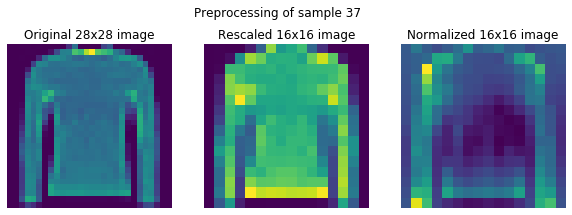

In [7]:
# Plot original and reshaped image
def plot_comparison(idx_to_plot, lists, titles):
    n_plots = len(lists)
    fig, ax = plt.subplots(1,n_plots, figsize=(10,10/n_plots))
    for i in range(n_plots):
        ax[i].imshow(lists[i][idx_to_plot])
        ax[i].set_title(titles[i])
        ax[i].axis("off")
    fig.suptitle(f"Preprocessing of sample {idx_to_plot}",y=1)
    plt.show()
    
plot_comparison(37,
                [X_train, X_train_small, X_train_norm],
                [f"Original {STANDARD_IMAGE_SIZE}x{STANDARD_IMAGE_SIZE} image",
                 f"Rescaled {DESIRED_IMAGE_SIZE}x{DESIRED_IMAGE_SIZE} image",
                 f"Normalized {DESIRED_IMAGE_SIZE}x{DESIRED_IMAGE_SIZE} image"])

In [8]:
# Replace and reshape X_train and X_test, for convenience
X_train = X_train_norm.reshape(n_samples_train, DESIRED_IMAGE_SIZE**2)
X_test = X_test_norm.reshape(n_samples_test, DESIRED_IMAGE_SIZE**2)

# NEAT

## Basic Run Function

In [9]:
def exp(x):
    return np.exp(np.clip(x, -float('inf'), 709.))

# def sigmoid(output):
#     output = [min(709., x) for x in output]
#     output = [max(-709., x) for x in output]
#     return [1 /(1 + exp(-x)) for x in output]

def softmax(output):
    e = exp(output)
    return e / e.sum()

In [10]:
def step(x):
    return 1.0*(x>0.0)

def wann_cos(x):
    x = max(-60.0, min(60.0, 5.0 * x))
    return math.cos(math.pi*x)

def wann_sin(x):
    x = max(-60.0, min(60.0, 5.0 * x))
    return math.sin(math.pi * x)
        
def wann_sigmoid(x):
    x = max(-60.0, min(60.0, 5.0 * x))
    return (math.tanh(x/2.0) + 1.0)/2.0

def wann_inverse(x):
    return -x

def wann_gauss(x):
    x = max(-3.4, min(3.4, x))
    return exp(- (x*x) / 2.0)

def run(config_file):
    # Load configuration.
    config = neat.Config(neat.DefaultGenome, neat.DefaultReproduction,
                         neat.DefaultSpeciesSet, neat.DefaultStagnation,
                         config_file)

    config.genome_config.add_activation('step', step)
    config.genome_config.add_activation('wcos', wann_cos)
    config.genome_config.add_activation('wsin', wann_sin)
    config.genome_config.add_activation('wsig', wann_sigmoid)
    config.genome_config.add_activation('winv', wann_inverse)
    config.genome_config.add_activation('wgauss', wann_gauss)
    
    # Create the population, which is the top-level object for a NEAT run.
    p = neat.Population(config)
    
    # Add a stdout reporter to show progress in the terminal.
    p.add_reporter(neat.StdOutReporter(True))
    stats = neat.StatisticsReporter()
    
    p.add_reporter(stats)
    p.add_reporter(neat.Checkpointer(50, filename_prefix='NEAT-checkpoints/neat-checkpoint-10-classes-fashion-'))
    
    
    # Run for up to NR_GENERATIONS generations.
    winner = p.run(eval_genomes, NR_GENERATIONS)
    stats.save_genome_fitness(filename="NEAT-results/fashion_fitness_history.csv")
    stats.save_species_count(filename="NEAT-results/fashion_species_count.csv")
    with open('NEAT-results/best_genomes_fashion', 'wb') as f:
        best_genomes = stats.best_genomes(10)
        pickle.dump(best_genomes,f)
    
    
    # Display the winning genome.
    print('\nBest genome:\n{!s}'.format(winner))


## Basic Evaluation Function

In [11]:
def eval_genomes(genomes, config):
    
    def _cross_entropy(pred, label):
        return -np.log(exp(pred[label])/np.sum(exp(pred), axis=0))
    
    sample_indices = []
    n_samples_per_class = int(N_SAMPLES_TO_TEST/N_CLASSES_TO_USE)
    for c in range(N_CLASSES_TO_USE):
        c_indices = np.where(Y_train == c)[0]
        assert len(c_indices) >= n_samples_per_class, \
            f"Class {c} has too few elements to reach the desired number of evaluation samples"
        sample_indices.extend(np.random.permutation(c_indices)[:n_samples_per_class])
    
    # Compute cross-entropy loss for each of the samples
    losses = []
    for i in sample_indices:
        X_sample, Y_sample = X_train[i], Y_train[i]
        
    
    for genome_id, genome in genomes:
        ce = []
        
        genome.fitness = 0.
        net = neat.nn.FeedForwardNetwork.create(genome, config)
        nr_correct = 0.
        for i in sample_indices:
            train, label = X_train[i], Y_train[i]
            output = softmax(net.activate(train))
            
            ce.append(-_cross_entropy(output, label))
#             if np.argmax(sigmoid(output)) == label:
#                 nr_correct += 1.

        genome.fitness = np.average(ce)           
    

In [12]:
run(CONFIG_FILE)


 ****** Running generation 0 ****** 

Population's average fitness: -2.33332 stdev: 0.03567
Best fitness: -2.21255 - size: (10, 128) - species 1 - id 53
Average adjusted fitness: 0.089
Mean genetic distance 2.316, standard deviation 0.251
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1    0   250     -2.2    0.089     0
Total extinctions: 0
Generation time: 11.429 sec

 ****** Running generation 1 ****** 

Population's average fitness: -2.31756 stdev: 0.03815
Best fitness: -2.21390 - size: (10, 128) - species 1 - id 53
Average adjusted fitness: 0.086
Mean genetic distance 2.100, standard deviation 0.621
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1    1   250     -2.2    0.086     1
Total extinctions: 0
Generation time: 11.283 sec (11.356 average)

 ****** Running generation 2 ****** 

Population's average fitness: -2.3

Mean genetic distance 0.641, standard deviation 0.102
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   17   250     -2.1    0.138     6
Total extinctions: 0
Generation time: 10.588 sec (10.336 average)

 ****** Running generation 18 ****** 

Population's average fitness: -2.25716 stdev: 0.06148
Best fitness: -2.13214 - size: (15, 131) - species 1 - id 4713
Average adjusted fitness: 0.153
Mean genetic distance 0.615, standard deviation 0.102
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   18   250     -2.1    0.153     7
Total extinctions: 0
Generation time: 10.565 sec (10.364 average)

 ****** Running generation 19 ****** 

Population's average fitness: -2.24941 stdev: 0.05933
Best fitness: -2.13270 - size: (15, 132) - species 1 - id 4822
Average adjusted fitness: 0.140
Mean genetic distance 0.643, standard deviation 0.

Population's average fitness: -2.24549 stdev: 0.06537
Best fitness: -2.11541 - size: (16, 132) - species 1 - id 8258
Average adjusted fitness: 0.168
Mean genetic distance 0.717, standard deviation 0.105
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   35   250     -2.1    0.168    13
Total extinctions: 0
Generation time: 10.761 sec (10.585 average)

 ****** Running generation 36 ****** 

Population's average fitness: -2.23157 stdev: 0.06721
Best fitness: -2.08876 - size: (12, 121) - species 1 - id 9171
Average adjusted fitness: 0.187
Mean genetic distance 0.775, standard deviation 0.094
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   36   250     -2.1    0.187    14
Total extinctions: 0
Generation time: 11.035 sec (10.605 average)

 ****** Running generation 37 ****** 

Population's average fitness: -2.22226 stdev: 0.06

Population's average fitness: -2.23056 stdev: 0.06544
Best fitness: -2.08120 - size: (16, 127) - species 1 - id 13230
Average adjusted fitness: 0.166
Mean genetic distance 0.890, standard deviation 0.173
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   53   250     -2.1    0.166     6
Total extinctions: 0
Generation time: 11.545 sec (11.260 average)

 ****** Running generation 54 ****** 

Population's average fitness: -2.22806 stdev: 0.06205
Best fitness: -2.09602 - size: (17, 129) - species 1 - id 13588
Average adjusted fitness: 0.160
Mean genetic distance 0.894, standard deviation 0.133
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   54   250     -2.1    0.160     7
Total extinctions: 0
Generation time: 11.155 sec (11.281 average)

 ****** Running generation 55 ****** 

Population's average fitness: -2.22076 stdev: 0.

Population's average fitness: -2.20506 stdev: 0.06913
Best fitness: -2.06711 - size: (18, 125) - species 1 - id 17517
Average adjusted fitness: 0.188
Mean genetic distance 0.860, standard deviation 0.088
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   71   250     -2.1    0.188     9
Total extinctions: 0
Generation time: 11.295 sec (11.199 average)

 ****** Running generation 72 ****** 

Population's average fitness: -2.22058 stdev: 0.06040
Best fitness: -2.08957 - size: (18, 125) - species 1 - id 17517
Average adjusted fitness: 0.182
Mean genetic distance 0.775, standard deviation 0.140
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   72   250     -2.1    0.182    10
Total extinctions: 0
Generation time: 11.170 sec (11.348 average)

 ****** Running generation 73 ****** 

Population's average fitness: -2.21921 stdev: 0.

Population's average fitness: -2.20797 stdev: 0.06913
Best fitness: -2.04188 - size: (16, 115) - species 1 - id 20937
Average adjusted fitness: 0.157
Mean genetic distance 0.839, standard deviation 0.115
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   89   250     -2.0    0.157     0
Total extinctions: 0
Generation time: 11.045 sec (11.202 average)

 ****** Running generation 90 ****** 

Population's average fitness: -2.23726 stdev: 0.05846
Best fitness: -2.10025 - size: (16, 115) - species 1 - id 20937
Average adjusted fitness: 0.160
Mean genetic distance 0.876, standard deviation 0.142
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   90   250     -2.1    0.160     1
Total extinctions: 0
Generation time: 11.019 sec (11.165 average)

 ****** Running generation 91 ****** 

Population's average fitness: -2.22523 stdev: 0.

Mean genetic distance 0.718, standard deviation 0.148
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  106   250     -2.0    0.185     6
Total extinctions: 0
Generation time: 10.859 sec (10.946 average)

 ****** Running generation 107 ****** 

Population's average fitness: -2.20745 stdev: 0.07163
Best fitness: -2.02288 - size: (17, 118) - species 1 - id 26741
Average adjusted fitness: 0.179
Mean genetic distance 0.741, standard deviation 0.147
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  107   250     -2.0    0.179     0
Total extinctions: 0
Generation time: 10.606 sec (10.896 average)

 ****** Running generation 108 ****** 

Population's average fitness: -2.20896 stdev: 0.05735
Best fitness: -2.05736 - size: (16, 118) - species 1 - id 27008
Average adjusted fitness: 0.196
Mean genetic distance 0.753, standard deviatio

Population's average fitness: -2.20515 stdev: 0.06565
Best fitness: -2.04482 - size: (16, 103) - species 1 - id 30328
Average adjusted fitness: 0.157
Mean genetic distance 0.732, standard deviation 0.194
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  124   250     -2.0    0.157     9
Total extinctions: 0
Generation time: 10.071 sec (10.548 average)

 ****** Running generation 125 ****** 

Population's average fitness: -2.20854 stdev: 0.07179
Best fitness: -2.06162 - size: (16, 108) - species 1 - id 30931
Average adjusted fitness: 0.192
Mean genetic distance 0.800, standard deviation 0.185
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  125   250     -2.1    0.192    10
Total extinctions: 0
Generation time: 10.154 sec (10.508 average)

 ****** Running generation 126 ****** 

Population's average fitness: -2.20325 stdev: 

Mean genetic distance 1.239, standard deviation 0.159
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  141   250     -2.0    0.184    12
Total extinctions: 0
Generation time: 10.493 sec (10.294 average)

 ****** Running generation 142 ****** 

Population's average fitness: -2.21318 stdev: 0.06633
Best fitness: -2.06971 - size: (14, 101) - species 1 - id 34979
Average adjusted fitness: 0.175
Mean genetic distance 1.276, standard deviation 0.152
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  142   250     -2.1    0.175    13
Total extinctions: 0
Generation time: 10.319 sec (10.305 average)

 ****** Running generation 143 ****** 

Population's average fitness: -2.20073 stdev: 0.06841
Best fitness: -2.04425 - size: (14, 101) - species 1 - id 34979
Average adjusted fitness: 0.174
Mean genetic distance 1.264, standard deviatio

Population's average fitness: -2.17901 stdev: 0.07029
Best fitness: -2.02054 - size: (12, 94) - species 1 - id 39600
Average adjusted fitness: 0.185
Mean genetic distance 0.907, standard deviation 0.164
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  159   250     -2.0    0.185    30
Total extinctions: 0
Generation time: 9.983 sec (10.088 average)

 ****** Running generation 160 ****** 

Population's average fitness: -2.18857 stdev: 0.07059
Best fitness: -2.03200 - size: (13, 93) - species 1 - id 39765
Average adjusted fitness: 0.203
Mean genetic distance 0.909, standard deviation 0.155
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  160   250     -2.0    0.203    31
Total extinctions: 0
Generation time: 9.810 sec (10.051 average)

 ****** Running generation 161 ****** 

Population's average fitness: -2.20139 stdev: 0.06

Population's average fitness: -2.18809 stdev: 0.06397
Best fitness: -2.02003 - size: (15, 105) - species 1 - id 42103
Average adjusted fitness: 0.176
Mean genetic distance 0.823, standard deviation 0.165
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  177   250     -2.0    0.176    48
Total extinctions: 0
Generation time: 9.866 sec (9.795 average)

 ****** Running generation 178 ****** 

Population's average fitness: -2.18447 stdev: 0.07022
Best fitness: -2.03040 - size: (15, 103) - species 1 - id 43343
Average adjusted fitness: 0.197
Mean genetic distance 0.744, standard deviation 0.172
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  178   250     -2.0    0.197    49
Total extinctions: 0
Generation time: 9.688 sec (9.785 average)

 ****** Running generation 179 ****** 

Population's average fitness: -2.19203 stdev: 0.06

Population's average fitness: -2.18806 stdev: 0.07470
Best fitness: -2.01089 - size: (13, 99) - species 1 - id 46160
Average adjusted fitness: 0.191
Mean genetic distance 1.128, standard deviation 0.214
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  195   250     -2.0    0.191    66
Total extinctions: 0
Generation time: 10.176 sec (10.085 average)

 ****** Running generation 196 ****** 

Population's average fitness: -2.18953 stdev: 0.07030
Best fitness: -2.00431 - size: (13, 99) - species 1 - id 46160
Average adjusted fitness: 0.185
Mean genetic distance 1.146, standard deviation 0.221
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  196   250     -2.0    0.185    67
Total extinctions: 0
Generation time: 10.207 sec (10.099 average)

 ****** Running generation 197 ****** 

Population's average fitness: -2.20971 stdev: 0.

Mean genetic distance 1.022, standard deviation 0.194
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  212   250     -2.0    0.158     8
Total extinctions: 0
Generation time: 10.592 sec (10.481 average)

 ****** Running generation 213 ****** 

Population's average fitness: -2.21032 stdev: 0.06148
Best fitness: -2.04457 - size: (15, 102) - species 1 - id 51365
Average adjusted fitness: 0.150
Mean genetic distance 1.005, standard deviation 0.220
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  213   250     -2.0    0.150     9
Total extinctions: 0
Generation time: 10.416 sec (10.468 average)

 ****** Running generation 214 ****** 

Population's average fitness: -2.20423 stdev: 0.05724
Best fitness: -2.04148 - size: (15, 102) - species 1 - id 51365
Average adjusted fitness: 0.136
Mean genetic distance 1.014, standard deviatio


 ****** Running generation 230 ****** 

Population's average fitness: -2.20394 stdev: 0.06074
Best fitness: -2.04082 - size: (15, 102) - species 1 - id 51365
Average adjusted fitness: 0.185
Mean genetic distance 0.940, standard deviation 0.257
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  230   250     -2.0    0.185    26
Total extinctions: 0
Generation time: 10.148 sec (10.365 average)

 ****** Running generation 231 ****** 

Population's average fitness: -2.19576 stdev: 0.06497
Best fitness: -2.01079 - size: (14, 100) - species 1 - id 56472
Average adjusted fitness: 0.164
Mean genetic distance 0.976, standard deviation 0.276
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  231   250     -2.0    0.164    27
Total extinctions: 0
Generation time: 10.245 sec (10.354 average)

 ****** Running generation 232 ****** 

Popul

Population's average fitness: -2.19743 stdev: 0.06918
Best fitness: -2.02577 - size: (15, 102) - species 1 - id 59348
Average adjusted fitness: 0.198
Mean genetic distance 0.886, standard deviation 0.277
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  248   250     -2.0    0.198    44
Total extinctions: 0
Generation time: 10.537 sec (10.268 average)

 ****** Running generation 249 ****** 

Population's average fitness: -2.20500 stdev: 0.06615
Best fitness: -2.03929 - size: (17, 102) - species 1 - id 61483
Average adjusted fitness: 0.162
Mean genetic distance 0.909, standard deviation 0.270
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  249   250     -2.0    0.162    45
Total extinctions: 0
Generation time: 10.279 sec (10.276 average)

 ****** Running generation 250 ****** 

Population's average fitness: -2.18784 stdev: 

Mean genetic distance 0.871, standard deviation 0.104
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  265   250     -2.0    0.168     6
Total extinctions: 0
Generation time: 10.800 sec (10.676 average)

 ****** Running generation 266 ****** 

Population's average fitness: -2.17825 stdev: 0.07300
Best fitness: -1.98517 - size: (17, 104) - species 1 - id 64073
Average adjusted fitness: 0.233
Mean genetic distance 0.912, standard deviation 0.116
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  266   250     -2.0    0.233     7
Total extinctions: 0
Generation time: 10.316 sec (10.644 average)

 ****** Running generation 267 ****** 

Population's average fitness: -2.20740 stdev: 0.07144
Best fitness: -2.02721 - size: (17, 104) - species 1 - id 64073
Average adjusted fitness: 0.206
Mean genetic distance 0.902, standard deviatio

Population's average fitness: -2.19939 stdev: 0.06220
Best fitness: -2.01866 - size: (17, 104) - species 1 - id 64073
Average adjusted fitness: 0.171
Mean genetic distance 0.760, standard deviation 0.119
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  283   250     -2.0    0.171     6
Total extinctions: 0
Generation time: 10.490 sec (10.646 average)

 ****** Running generation 284 ****** 

Population's average fitness: -2.18843 stdev: 0.07083
Best fitness: -2.01445 - size: (17, 104) - species 1 - id 64073
Average adjusted fitness: 0.169
Mean genetic distance 0.770, standard deviation 0.106
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  284   250     -2.0    0.169     7
Total extinctions: 0
Generation time: 10.974 sec (10.707 average)

 ****** Running generation 285 ****** 

Population's average fitness: -2.18783 stdev: 

Population's average fitness: -2.18249 stdev: 0.07407
Best fitness: -1.99098 - size: (11, 94) - species 1 - id 74798
Average adjusted fitness: 0.217
Mean genetic distance 0.587, standard deviation 0.091
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  301   250     -2.0    0.217     9
Total extinctions: 0
Generation time: 9.822 sec (9.828 average)

 ****** Running generation 302 ****** 

Population's average fitness: -2.18861 stdev: 0.06327
Best fitness: -2.03651 - size: (11, 94) - species 1 - id 74798
Average adjusted fitness: 0.196
Mean genetic distance 0.568, standard deviation 0.095
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  302   250     -2.0    0.196    10
Total extinctions: 0
Generation time: 9.806 sec (9.821 average)

 ****** Running generation 303 ****** 

Population's average fitness: -2.19608 stdev: 0.0566

Population's average fitness: -2.19554 stdev: 0.06127
Best fitness: -2.03662 - size: (13, 95) - species 1 - id 77419
Average adjusted fitness: 0.184
Mean genetic distance 0.687, standard deviation 0.095
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  319   250     -2.0    0.184    27
Total extinctions: 0
Generation time: 9.904 sec (9.919 average)
Saving checkpoint to NEAT-checkpoints/neat-checkpoint-10-classes-fashion-319

 ****** Running generation 320 ****** 

Population's average fitness: -2.18580 stdev: 0.06868
Best fitness: -2.01808 - size: (13, 95) - species 1 - id 77419
Average adjusted fitness: 0.221
Mean genetic distance 0.652, standard deviation 0.103
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  320   250     -2.0    0.221    28
Total extinctions: 0
Generation time: 10.042 sec (9.911 average)

 ****** Runnin

Population's average fitness: -2.17611 stdev: 0.07268
Best fitness: -1.99792 - size: (11, 84) - species 1 - id 83274
Average adjusted fitness: 0.176
Mean genetic distance 0.737, standard deviation 0.107
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  337   250     -2.0    0.176     7
Total extinctions: 0
Generation time: 10.002 sec (9.981 average)

 ****** Running generation 338 ****** 

Population's average fitness: -2.18078 stdev: 0.07160
Best fitness: -2.00301 - size: (12, 87) - species 1 - id 83907
Average adjusted fitness: 0.201
Mean genetic distance 0.780, standard deviation 0.118
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  338   250     -2.0    0.201     8
Total extinctions: 0
Generation time: 9.935 sec (9.964 average)

 ****** Running generation 339 ****** 

Population's average fitness: -2.19810 stdev: 0.062

Population's average fitness: -2.17850 stdev: 0.07205
Best fitness: -2.00565 - size: (14, 86) - species 1 - id 88069
Average adjusted fitness: 0.199
Mean genetic distance 0.994, standard deviation 0.161
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  355   250     -2.0    0.199    25
Total extinctions: 0
Generation time: 10.574 sec (10.121 average)

 ****** Running generation 356 ****** 

Population's average fitness: -2.16415 stdev: 0.06774
Best fitness: -1.97353 - size: (14, 86) - species 1 - id 88297
Average adjusted fitness: 0.225
Mean genetic distance 0.937, standard deviation 0.253
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  356   250     -2.0    0.225    26
Total extinctions: 0
Generation time: 10.377 sec (10.169 average)

 ****** Running generation 357 ****** 

Population's average fitness: -2.18416 stdev: 0.

Population's average fitness: -2.18138 stdev: 0.06792
Best fitness: -1.99481 - size: (15, 86) - species 1 - id 90626
Average adjusted fitness: 0.214
Mean genetic distance 0.782, standard deviation 0.118
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  373   250     -2.0    0.214    43
Total extinctions: 0
Generation time: 10.140 sec (10.317 average)

 ****** Running generation 374 ****** 

Population's average fitness: -2.16694 stdev: 0.07550
Best fitness: -1.97188 - size: (15, 86) - species 1 - id 90626
Average adjusted fitness: 0.217
Mean genetic distance 0.761, standard deviation 0.152
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  374   250     -2.0    0.217    44
Total extinctions: 0
Generation time: 10.079 sec (10.285 average)

 ****** Running generation 375 ****** 

Population's average fitness: -2.18836 stdev: 0.

Population's average fitness: -2.17770 stdev: 0.07107
Best fitness: -1.98579 - size: (13, 86) - species 1 - id 96515
Average adjusted fitness: 0.202
Mean genetic distance 0.687, standard deviation 0.140
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  391   250     -2.0    0.202     6
Total extinctions: 0
Generation time: 10.243 sec (10.044 average)

 ****** Running generation 392 ****** 

Population's average fitness: -2.17594 stdev: 0.06367
Best fitness: -1.99274 - size: (13, 86) - species 1 - id 96515
Average adjusted fitness: 0.216
Mean genetic distance 0.729, standard deviation 0.139
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  392   250     -2.0    0.216     7
Total extinctions: 0
Generation time: 9.938 sec (10.076 average)

 ****** Running generation 393 ****** 

Population's average fitness: -2.19226 stdev: 0.0

Population's average fitness: -2.17809 stdev: 0.06375
Best fitness: -1.99378 - size: (11, 78) - species 1 - id 99542
Average adjusted fitness: 0.219
Mean genetic distance 0.778, standard deviation 0.146
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  409   250     -2.0    0.219    24
Total extinctions: 0
Generation time: 9.714 sec (9.746 average)

 ****** Running generation 410 ****** 

Population's average fitness: -2.18064 stdev: 0.06352
Best fitness: -1.99225 - size: (11, 78) - species 1 - id 99542
Average adjusted fitness: 0.147
Mean genetic distance 0.780, standard deviation 0.153
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  410   250     -2.0    0.147    25
Total extinctions: 0
Generation time: 9.739 sec (9.719 average)
Saving checkpoint to NEAT-checkpoints/neat-checkpoint-10-classes-fashion-410

 ****** Running

Mean genetic distance 0.713, standard deviation 0.214
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  426   250     -2.0    0.161    11
Total extinctions: 0
Generation time: 9.959 sec (9.783 average)

 ****** Running generation 427 ****** 

Population's average fitness: -2.20726 stdev: 0.06219
Best fitness: -2.04341 - size: (11, 78) - species 1 - id 99542
Average adjusted fitness: 0.148
Mean genetic distance 0.742, standard deviation 0.216
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  427   250     -2.0    0.148    12
Total extinctions: 0
Generation time: 9.897 sec (9.795 average)

 ****** Running generation 428 ****** 

Population's average fitness: -2.18336 stdev: 0.06545
Best fitness: -2.00660 - size: (11, 78) - species 1 - id 99542
Average adjusted fitness: 0.195
Mean genetic distance 0.802, standard deviation 0.19

Population's average fitness: -2.18953 stdev: 0.06900
Best fitness: -2.01374 - size: (11, 78) - species 1 - id 99542
Average adjusted fitness: 0.182
Mean genetic distance 0.724, standard deviation 0.238
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  444   250     -2.0    0.182    15
Total extinctions: 0
Generation time: 9.859 sec (10.268 average)

 ****** Running generation 445 ****** 

Population's average fitness: -2.18310 stdev: 0.06993
Best fitness: -1.99125 - size: (11, 78) - species 1 - id 99542
Average adjusted fitness: 0.183
Mean genetic distance 0.738, standard deviation 0.220
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  445   250     -2.0    0.183    16
Total extinctions: 0
Generation time: 9.619 sec (10.175 average)

 ****** Running generation 446 ****** 

Population's average fitness: -2.17214 stdev: 0.06

Mean genetic distance 0.558, standard deviation 0.113
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  461   250     -2.0    0.196     1
Total extinctions: 0
Generation time: 9.233 sec (9.201 average)

 ****** Running generation 462 ****** 

Population's average fitness: -2.18923 stdev: 0.06490
Best fitness: -2.01050 - size: (12, 76) - species 1 - id 113534
Average adjusted fitness: 0.199
Mean genetic distance 0.572, standard deviation 0.106
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  462   250     -2.0    0.199     2
Total extinctions: 0
Generation time: 9.288 sec (9.176 average)

 ****** Running generation 463 ****** 

Population's average fitness: -2.18545 stdev: 0.06951
Best fitness: -1.99232 - size: (11, 78) - species 1 - id 99542
Average adjusted fitness: 0.198
Mean genetic distance 0.569, standard deviation 0.1

Population's average fitness: -2.19219 stdev: 0.06502
Best fitness: -1.99429 - size: (11, 78) - species 1 - id 99542
Average adjusted fitness: 0.143
Mean genetic distance 0.536, standard deviation 0.096
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  479   250     -2.0    0.143    19
Total extinctions: 0
Generation time: 9.412 sec (9.239 average)

 ****** Running generation 480 ****** 

Population's average fitness: -2.18136 stdev: 0.06898
Best fitness: -1.97514 - size: (11, 78) - species 1 - id 99542
Average adjusted fitness: 0.181
Mean genetic distance 0.545, standard deviation 0.097
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  480   250     -2.0    0.181    20
Total extinctions: 0
Generation time: 9.352 sec (9.258 average)

 ****** Running generation 481 ****** 

Population's average fitness: -2.19081 stdev: 0.0652

Population's average fitness: -2.19435 stdev: 0.06883
Best fitness: -2.00250 - size: (11, 78) - species 1 - id 99542
Average adjusted fitness: 0.173
Mean genetic distance 0.558, standard deviation 0.143
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  497   250     -2.0    0.173    37
Total extinctions: 0
Generation time: 9.483 sec (9.343 average)

 ****** Running generation 498 ****** 

Population's average fitness: -2.18044 stdev: 0.07034
Best fitness: -1.97692 - size: (11, 78) - species 1 - id 99542
Average adjusted fitness: 0.194
Mean genetic distance 0.551, standard deviation 0.130
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  498   250     -2.0    0.194    38
Total extinctions: 0
Generation time: 9.428 sec (9.379 average)

 ****** Running generation 499 ****** 

Population's average fitness: -2.17945 stdev: 0.0710

Population's average fitness: -2.17829 stdev: 0.06405
Best fitness: -1.97954 - size: (11, 78) - species 1 - id 99542
Average adjusted fitness: 0.196
Mean genetic distance 0.550, standard deviation 0.191
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  515   250     -2.0    0.196     6
Total extinctions: 0
Generation time: 9.627 sec (9.550 average)

 ****** Running generation 516 ****** 

Population's average fitness: -2.16890 stdev: 0.07027
Best fitness: -1.96385 - size: (11, 78) - species 1 - id 99542
Average adjusted fitness: 0.180
Mean genetic distance 0.516, standard deviation 0.161
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  516   250     -2.0    0.180     7
Total extinctions: 0
Generation time: 9.316 sec (9.529 average)

 ****** Running generation 517 ****** 

Population's average fitness: -2.19343 stdev: 0.0612

Population's average fitness: -2.18291 stdev: 0.07026
Best fitness: -1.98200 - size: (10, 75) - species 1 - id 127588
Average adjusted fitness: 0.193
Mean genetic distance 0.542, standard deviation 0.127
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  533   250     -2.0    0.193    24
Total extinctions: 0
Generation time: 9.763 sec (9.414 average)

 ****** Running generation 534 ****** 

Population's average fitness: -2.17403 stdev: 0.06978
Best fitness: -1.97911 - size: (11, 78) - species 1 - id 99542
Average adjusted fitness: 0.173
Mean genetic distance 0.546, standard deviation 0.124
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  534   250     -2.0    0.173    25
Total extinctions: 0
Generation time: 9.060 sec (9.397 average)

 ****** Running generation 535 ****** 

Population's average fitness: -2.20568 stdev: 0.068

Mean genetic distance 0.524, standard deviation 0.123
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  550   250     -2.0    0.196    41
Total extinctions: 0
Generation time: 9.459 sec (9.353 average)

 ****** Running generation 551 ****** 

Population's average fitness: -2.19255 stdev: 0.07012
Best fitness: -2.02093 - size: (11, 78) - species 1 - id 99542
Average adjusted fitness: 0.190
Mean genetic distance 0.501, standard deviation 0.130
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  551   250     -2.0    0.190    42
Total extinctions: 0
Generation time: 9.279 sec (9.354 average)

 ****** Running generation 552 ****** 

Population's average fitness: -2.16219 stdev: 0.07480
Best fitness: -1.96512 - size: (11, 78) - species 1 - id 136523
Average adjusted fitness: 0.183
Mean genetic distance 0.510, standard deviation 0.1

Population's average fitness: -2.17520 stdev: 0.07129
Best fitness: -1.97909 - size: (11, 78) - species 1 - id 136523
Average adjusted fitness: 0.176
Mean genetic distance 0.540, standard deviation 0.118
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  568   250     -2.0    0.176    59
Total extinctions: 0
Generation time: 9.581 sec (9.368 average)

 ****** Running generation 569 ****** 

Population's average fitness: -2.16689 stdev: 0.07297
Best fitness: -1.97059 - size: (11, 78) - species 1 - id 136523
Average adjusted fitness: 0.203
Mean genetic distance 0.540, standard deviation 0.110
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  569   250     -2.0    0.203    60
Total extinctions: 0
Generation time: 9.336 sec (9.365 average)

 ****** Running generation 570 ****** 

Population's average fitness: -2.18723 stdev: 0.07

Population's average fitness: -2.18121 stdev: 0.07055
Best fitness: -1.99869 - size: (11, 78) - species 1 - id 136523
Average adjusted fitness: 0.211
Mean genetic distance 0.586, standard deviation 0.125
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  586   250     -2.0    0.211    77
Total extinctions: 0
Generation time: 9.389 sec (9.265 average)

 ****** Running generation 587 ****** 

Population's average fitness: -2.17601 stdev: 0.07047
Best fitness: -1.99181 - size: (11, 78) - species 1 - id 136523
Average adjusted fitness: 0.172
Mean genetic distance 0.601, standard deviation 0.126
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  587   250     -2.0    0.172    78
Total extinctions: 0
Generation time: 9.179 sec (9.240 average)

 ****** Running generation 588 ****** 

Population's average fitness: -2.17288 stdev: 0.06

Population's average fitness: -2.19108 stdev: 0.06498
Best fitness: -2.02153 - size: (12, 75) - species 1 - id 148499
Average adjusted fitness: 0.172
Mean genetic distance 0.585, standard deviation 0.121
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  604   250     -2.0    0.172    95
Total extinctions: 0
Generation time: 9.235 sec (9.236 average)
Saving checkpoint to NEAT-checkpoints/neat-checkpoint-10-classes-fashion-604

 ****** Running generation 605 ****** 

Population's average fitness: -2.17645 stdev: 0.06314
Best fitness: -2.01303 - size: (11, 78) - species 1 - id 136523
Average adjusted fitness: 0.178
Mean genetic distance 0.585, standard deviation 0.134
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  605   250     -2.0    0.178    96
Total extinctions: 0
Generation time: 9.323 sec (9.247 average)

 ****** Runni

Mean genetic distance 0.559, standard deviation 0.144
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  621   250     -2.0    0.172   112
Total extinctions: 0
Generation time: 9.270 sec (9.365 average)

 ****** Running generation 622 ****** 

Population's average fitness: -2.18057 stdev: 0.06785
Best fitness: -1.98827 - size: (11, 78) - species 1 - id 150494
Average adjusted fitness: 0.177
Mean genetic distance 0.535, standard deviation 0.116
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  622   250     -2.0    0.177   113
Total extinctions: 0
Generation time: 9.260 sec (9.352 average)

 ****** Running generation 623 ****** 

Population's average fitness: -2.18955 stdev: 0.06773
Best fitness: -1.99176 - size: (11, 78) - species 1 - id 150494
Average adjusted fitness: 0.175
Mean genetic distance 0.536, standard deviation 0.

Population's average fitness: -2.17129 stdev: 0.06701
Best fitness: -1.99366 - size: (11, 78) - species 1 - id 150494
Average adjusted fitness: 0.238
Mean genetic distance 0.492, standard deviation 0.109
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  639   250     -2.0    0.238   130
Total extinctions: 0
Generation time: 9.532 sec (9.370 average)

 ****** Running generation 640 ****** 

Population's average fitness: -2.18543 stdev: 0.06564
Best fitness: -1.99543 - size: (11, 76) - species 1 - id 158924
Average adjusted fitness: 0.167
Mean genetic distance 0.487, standard deviation 0.109
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  640   250     -2.0    0.167   131
Total extinctions: 0
Generation time: 9.556 sec (9.383 average)

 ****** Running generation 641 ****** 

Population's average fitness: -2.18841 stdev: 0.06

Population's average fitness: -2.22132 stdev: 0.05870
Best fitness: -2.05130 - size: (12, 78) - species 1 - id 158982
Average adjusted fitness: 0.159
Mean genetic distance 0.632, standard deviation 0.098
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  657   250     -2.1    0.159   148
Total extinctions: 0
Generation time: 9.549 sec (9.624 average)

 ****** Running generation 658 ****** 

Population's average fitness: -2.17197 stdev: 0.07450
Best fitness: -1.97288 - size: (12, 78) - species 1 - id 158982
Average adjusted fitness: 0.220
Mean genetic distance 0.616, standard deviation 0.109
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  658   250     -2.0    0.220   149
Total extinctions: 0
Generation time: 9.772 sec (9.616 average)

 ****** Running generation 659 ****** 

Population's average fitness: -2.18939 stdev: 0.06

Population's average fitness: -2.18519 stdev: 0.06531
Best fitness: -2.01824 - size: (12, 80) - species 1 - id 167586
Average adjusted fitness: 0.204
Mean genetic distance 0.708, standard deviation 0.148
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  675   250     -2.0    0.204   166
Total extinctions: 0
Generation time: 9.783 sec (9.704 average)

 ****** Running generation 676 ****** 

Population's average fitness: -2.17419 stdev: 0.06578
Best fitness: -1.98900 - size: (12, 81) - species 1 - id 167356
Average adjusted fitness: 0.182
Mean genetic distance 0.705, standard deviation 0.168
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  676   250     -2.0    0.182   167
Total extinctions: 0
Generation time: 9.520 sec (9.671 average)

 ****** Running generation 677 ****** 

Population's average fitness: -2.16874 stdev: 0.07

Population's average fitness: -2.18383 stdev: 0.06506
Best fitness: -2.00919 - size: (12, 81) - species 1 - id 168371
Average adjusted fitness: 0.174
Mean genetic distance 0.577, standard deviation 0.126
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  693   250     -2.0    0.174   184
Total extinctions: 0
Generation time: 9.730 sec (9.587 average)

 ****** Running generation 694 ****** 

Population's average fitness: -2.17638 stdev: 0.06730
Best fitness: -1.98289 - size: (12, 81) - species 1 - id 168371
Average adjusted fitness: 0.164
Mean genetic distance 0.577, standard deviation 0.121
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  694   250     -2.0    0.164   185
Total extinctions: 0
Generation time: 9.677 sec (9.611 average)

 ****** Running generation 695 ****** 

Population's average fitness: -2.17640 stdev: 0.06

Population's average fitness: -2.18488 stdev: 0.07016
Best fitness: -1.98719 - size: (12, 81) - species 1 - id 168371
Average adjusted fitness: 0.172
Mean genetic distance 0.605, standard deviation 0.145
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  711   250     -2.0    0.172   202
Total extinctions: 0
Generation time: 9.687 sec (9.661 average)

 ****** Running generation 712 ****** 

Population's average fitness: -2.18703 stdev: 0.07266
Best fitness: -1.99505 - size: (13, 80) - species 1 - id 175434
Average adjusted fitness: 0.181
Mean genetic distance 0.640, standard deviation 0.158
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  712   250     -2.0    0.181   203
Total extinctions: 0
Generation time: 9.608 sec (9.668 average)

 ****** Running generation 713 ****** 

Population's average fitness: -2.19055 stdev: 0.06

Population's average fitness: -2.17858 stdev: 0.06739
Best fitness: -2.00231 - size: (11, 75) - species 1 - id 180510
Average adjusted fitness: 0.164
Mean genetic distance 0.548, standard deviation 0.086
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  729   250     -2.0    0.164   220
Total extinctions: 0
Generation time: 9.415 sec (9.520 average)

 ****** Running generation 730 ****** 

Population's average fitness: -2.18950 stdev: 0.07118
Best fitness: -1.96377 - size: (10, 75) - species 1 - id 179332
Average adjusted fitness: 0.199
Mean genetic distance 0.544, standard deviation 0.089
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  730   250     -2.0    0.199   221
Total extinctions: 0
Generation time: 9.526 sec (9.520 average)

 ****** Running generation 731 ****** 

Population's average fitness: -2.20570 stdev: 0.06

Population's average fitness: -2.20427 stdev: 0.06631
Best fitness: -2.01096 - size: (10, 75) - species 1 - id 184415
Average adjusted fitness: 0.172
Mean genetic distance 0.511, standard deviation 0.118
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  747   250     -2.0    0.172   238
Total extinctions: 0
Generation time: 9.236 sec (9.339 average)

 ****** Running generation 748 ****** 

Population's average fitness: -2.19864 stdev: 0.06894
Best fitness: -2.01045 - size: (10, 75) - species 1 - id 179332
Average adjusted fitness: 0.167
Mean genetic distance 0.482, standard deviation 0.108
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  748   250     -2.0    0.167   239
Total extinctions: 0
Generation time: 9.514 sec (9.362 average)

 ****** Running generation 749 ****** 

Population's average fitness: -2.18940 stdev: 0.06


 ****** Running generation 765 ****** 

Population's average fitness: -2.18560 stdev: 0.06923
Best fitness: -2.02227 - size: (11, 72) - species 1 - id 188678
Average adjusted fitness: 0.175
Mean genetic distance 0.667, standard deviation 0.138
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  765   250     -2.0    0.175   256
Total extinctions: 0
Generation time: 9.357 sec (9.529 average)

 ****** Running generation 766 ****** 

Population's average fitness: -2.18113 stdev: 0.06637
Best fitness: -2.00715 - size: (11, 72) - species 1 - id 188678
Average adjusted fitness: 0.154
Mean genetic distance 0.710, standard deviation 0.153
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  766   250     -2.0    0.154   257
Total extinctions: 0
Generation time: 9.694 sec (9.541 average)

 ****** Running generation 767 ****** 

Populatio

Population's average fitness: -2.19416 stdev: 0.07384
Best fitness: -1.98096 - size: (14, 83) - species 1 - id 193564
Average adjusted fitness: 0.193
Mean genetic distance 0.761, standard deviation 0.162
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  783   250     -2.0    0.193   274
Total extinctions: 0
Generation time: 10.191 sec (9.875 average)

 ****** Running generation 784 ****** 

Population's average fitness: -2.20424 stdev: 0.06827
Best fitness: -2.01815 - size: (15, 86) - species 1 - id 192755
Average adjusted fitness: 0.169
Mean genetic distance 0.824, standard deviation 0.157
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  784   250     -2.0    0.169   275
Total extinctions: 0
Generation time: 10.216 sec (9.923 average)

 ****** Running generation 785 ****** 

Population's average fitness: -2.19027 stdev: 0.

Population's average fitness: -2.18781 stdev: 0.06520
Best fitness: -2.02846 - size: (13, 80) - species 1 - id 197995
Average adjusted fitness: 0.169
Mean genetic distance 0.687, standard deviation 0.148
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  801   250     -2.0    0.169   292
Total extinctions: 0
Generation time: 9.596 sec (9.664 average)

 ****** Running generation 802 ****** 

Population's average fitness: -2.18080 stdev: 0.06359
Best fitness: -2.00192 - size: (13, 80) - species 1 - id 197995
Average adjusted fitness: 0.166
Mean genetic distance 0.789, standard deviation 0.154
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  802   250     -2.0    0.166   293
Total extinctions: 0
Generation time: 9.793 sec (9.684 average)

 ****** Running generation 803 ****** 

Population's average fitness: -2.19087 stdev: 0.07

Population's average fitness: -2.16220 stdev: 0.06635
Best fitness: -1.98539 - size: (14, 83) - species 1 - id 201857
Average adjusted fitness: 0.166
Mean genetic distance 0.818, standard deviation 0.159
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  819   250     -2.0    0.166   310
Total extinctions: 0
Generation time: 9.774 sec (10.089 average)

 ****** Running generation 820 ****** 

Population's average fitness: -2.18540 stdev: 0.06720
Best fitness: -1.98457 - size: (14, 83) - species 1 - id 201857
Average adjusted fitness: 0.145
Mean genetic distance 0.877, standard deviation 0.147
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  820   250     -2.0    0.145   311
Total extinctions: 0
Generation time: 10.167 sec (10.093 average)

 ****** Running generation 821 ****** 

Population's average fitness: -2.19092 stdev: 0

Population's average fitness: -2.17893 stdev: 0.06761
Best fitness: -1.99721 - size: (14, 81) - species 1 - id 204069
Average adjusted fitness: 0.185
Mean genetic distance 0.735, standard deviation 0.082
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  837   250     -2.0    0.185   328
Total extinctions: 0
Generation time: 10.081 sec (9.825 average)

 ****** Running generation 838 ****** 

Population's average fitness: -2.17982 stdev: 0.07021
Best fitness: -1.99335 - size: (14, 81) - species 1 - id 204069
Average adjusted fitness: 0.177
Mean genetic distance 0.747, standard deviation 0.072
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  838   250     -2.0    0.177   329
Total extinctions: 0
Generation time: 10.167 sec (9.865 average)

 ****** Running generation 839 ****** 

Population's average fitness: -2.18478 stdev: 0.

Population's average fitness: -2.17582 stdev: 0.07084
Best fitness: -2.00690 - size: (14, 79) - species 1 - id 209008
Average adjusted fitness: 0.229
Mean genetic distance 0.729, standard deviation 0.086
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  855   250     -2.0    0.229   346
Total extinctions: 0
Generation time: 9.987 sec (9.996 average)

 ****** Running generation 856 ****** 

Population's average fitness: -2.18263 stdev: 0.07220
Best fitness: -2.00687 - size: (14, 79) - species 1 - id 209008
Average adjusted fitness: 0.170
Mean genetic distance 0.721, standard deviation 0.096
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  856   250     -2.0    0.170   347
Total extinctions: 0
Generation time: 9.936 sec (9.996 average)

 ****** Running generation 857 ****** 

Population's average fitness: -2.18245 stdev: 0.06

Population's average fitness: -2.19028 stdev: 0.06311
Best fitness: -2.01587 - size: (14, 81) - species 1 - id 215301
Average adjusted fitness: 0.186
Mean genetic distance 0.662, standard deviation 0.137
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  873   250     -2.0    0.186   364
Total extinctions: 0
Generation time: 9.882 sec (9.851 average)

 ****** Running generation 874 ****** 

Population's average fitness: -2.17964 stdev: 0.06579
Best fitness: -2.01246 - size: (14, 81) - species 1 - id 213579
Average adjusted fitness: 0.182
Mean genetic distance 0.665, standard deviation 0.151
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  874   250     -2.0    0.182   365
Total extinctions: 0
Generation time: 9.909 sec (9.854 average)

 ****** Running generation 875 ****** 

Population's average fitness: -2.16666 stdev: 0.07

Mean genetic distance 0.800, standard deviation 0.203
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  890   250     -2.0    0.228   381
Total extinctions: 0
Generation time: 10.715 sec (9.949 average)

 ****** Running generation 891 ****** 

Population's average fitness: -2.17229 stdev: 0.07039
Best fitness: -1.98640 - size: (14, 80) - species 1 - id 220653
Average adjusted fitness: 0.213
Mean genetic distance 0.708, standard deviation 0.167
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  891   250     -2.0    0.213   382
Total extinctions: 0
Generation time: 10.196 sec (9.974 average)

 ****** Running generation 892 ****** 

Population's average fitness: -2.18645 stdev: 0.06133
Best fitness: -2.02644 - size: (14, 80) - species 1 - id 220653
Average adjusted fitness: 0.170
Mean genetic distance 0.683, standard deviation 

Population's average fitness: -2.18285 stdev: 0.06752
Best fitness: -1.99439 - size: (14, 80) - species 1 - id 223224
Average adjusted fitness: 0.163
Mean genetic distance 0.566, standard deviation 0.140
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  908   250     -2.0    0.163   399
Total extinctions: 0
Generation time: 9.873 sec (10.011 average)

 ****** Running generation 909 ****** 

Population's average fitness: -2.17627 stdev: 0.06853
Best fitness: -1.97857 - size: (14, 80) - species 1 - id 223224
Average adjusted fitness: 0.195
Mean genetic distance 0.577, standard deviation 0.128
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  909   250     -2.0    0.195   400
Total extinctions: 0
Generation time: 9.820 sec (9.959 average)

 ****** Running generation 910 ****** 

Population's average fitness: -2.18889 stdev: 0.0

Population's average fitness: -2.17868 stdev: 0.07291
Best fitness: -1.97191 - size: (15, 81) - species 1 - id 226504
Average adjusted fitness: 0.226
Mean genetic distance 0.649, standard deviation 0.224
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  926   250     -2.0    0.226   417
Total extinctions: 0
Generation time: 10.301 sec (10.284 average)

 ****** Running generation 927 ****** 

Population's average fitness: -2.18356 stdev: 0.07775
Best fitness: -1.97846 - size: (15, 81) - species 1 - id 226504
Average adjusted fitness: 0.196
Mean genetic distance 0.595, standard deviation 0.202
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  927   250     -2.0    0.196   418
Total extinctions: 0
Generation time: 10.491 sec (10.317 average)

 ****** Running generation 928 ****** 

Population's average fitness: -2.19806 stdev: 

Population's average fitness: -2.19233 stdev: 0.06886
Best fitness: -2.00926 - size: (14, 74) - species 1 - id 234184
Average adjusted fitness: 0.191
Mean genetic distance 0.645, standard deviation 0.127
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  944   250     -2.0    0.191   435
Total extinctions: 0
Generation time: 10.078 sec (10.016 average)

 ****** Running generation 945 ****** 

Population's average fitness: -2.20379 stdev: 0.05974
Best fitness: -2.02945 - size: (15, 81) - species 1 - id 226504
Average adjusted fitness: 0.152
Mean genetic distance 0.686, standard deviation 0.127
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  945   250     -2.0    0.152   436
Total extinctions: 0
Generation time: 10.004 sec (10.034 average)

 ****** Running generation 946 ****** 

Population's average fitness: -2.19147 stdev: 

Population's average fitness: -2.18419 stdev: 0.07502
Best fitness: -1.98382 - size: (13, 75) - species 1 - id 235519
Average adjusted fitness: 0.160
Mean genetic distance 0.867, standard deviation 0.120
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  962   250     -2.0    0.160   453
Total extinctions: 0
Generation time: 9.837 sec (9.880 average)

 ****** Running generation 963 ****** 

Population's average fitness: -2.18514 stdev: 0.07295
Best fitness: -1.99852 - size: (13, 75) - species 1 - id 235519
Average adjusted fitness: 0.206
Mean genetic distance 0.842, standard deviation 0.134
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  963   250     -2.0    0.206   454
Total extinctions: 0
Generation time: 9.670 sec (9.857 average)

 ****** Running generation 964 ****** 

Population's average fitness: -2.18774 stdev: 0.06

Mean genetic distance 0.674, standard deviation 0.139
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  979   250     -2.0    0.198   470
Total extinctions: 0
Generation time: 9.819 sec (9.602 average)
Saving checkpoint to NEAT-checkpoints/neat-checkpoint-10-classes-fashion-979

 ****** Running generation 980 ****** 

Population's average fitness: -2.18786 stdev: 0.07339
Best fitness: -1.96776 - size: (13, 75) - species 1 - id 235519
Average adjusted fitness: 0.194
Mean genetic distance 0.644, standard deviation 0.139
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  980   250     -2.0    0.194   471
Total extinctions: 0
Generation time: 9.726 sec (9.610 average)

 ****** Running generation 981 ****** 

Population's average fitness: -2.19557 stdev: 0.07106
Best fitness: -1.98615 - size: (13, 75) - species 1 - id 235519
Avera

Population's average fitness: -2.19718 stdev: 0.06907
Best fitness: -1.99931 - size: (12, 69) - species 1 - id 246875
Average adjusted fitness: 0.169
Mean genetic distance 0.672, standard deviation 0.123
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  997   250     -2.0    0.169   488
Total extinctions: 0
Generation time: 9.875 sec (9.900 average)

 ****** Running generation 998 ****** 

Population's average fitness: -2.17954 stdev: 0.06963
Best fitness: -2.01858 - size: (12, 69) - species 1 - id 246875
Average adjusted fitness: 0.222
Mean genetic distance 0.687, standard deviation 0.127
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  998   250     -2.0    0.222   489
Total extinctions: 0
Generation time: 10.102 sec (9.925 average)

 ****** Running generation 999 ****** 

Population's average fitness: -2.19728 stdev: 0.0

## Plot History

In [13]:
history = np.genfromtxt('NEAT-results/fashion_fitness_history.csv', delimiter='')
best_fitness = history[:,0]
avg_fitness = history[:,1]

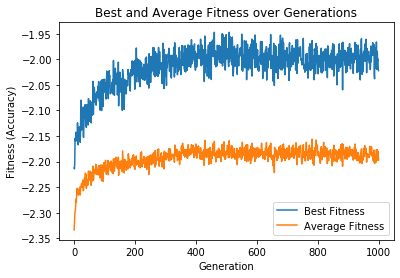

In [14]:
plt.plot(best_fitness, label = 'Best Fitness')
plt.plot(avg_fitness, label = 'Average Fitness')
plt.title('Best and Average Fitness over Generations')
plt.xlabel('Generation')
plt.ylabel('Fitness (Accuracy)')
plt.legend()
plt.show()

## Load and Test Fittest Member

In [21]:
def test_fittest(config_file):
    config = neat.Config(neat.DefaultGenome, neat.DefaultReproduction,
                         neat.DefaultSpeciesSet, neat.DefaultStagnation,
                         config_file)
    config.genome_config.add_activation('step', step)
    config.genome_config.add_activation('wcos', wann_cos)
    config.genome_config.add_activation('wsin', wann_sin)
    config.genome_config.add_activation('wsig', wann_sigmoid)
    config.genome_config.add_activation('winv', wann_inverse)
    config.genome_config.add_activation('wgauss', wann_gauss)
    preds_test = []
    preds_train = []
    train_correct = 0.
    test_correct = 0. 
    fittest_genome = pickle.load( open('NEAT-results/best_genomes_fashion', 'rb'))[0]
    #print(fittest_genome)
    net = neat.nn.FeedForwardNetwork.create(fittest_genome, config)
        
    for train, label in zip(X_train, Y_train):
        output = np.argmax(softmax(net.activate(train)))
        preds_train.append(output)
        if output == label:
            train_correct += 1.
    train_acc = train_correct / len(X_train)
    
    for test, label in zip(X_test, Y_test):
        output = np.argmax(softmax(net.activate(test)))
        preds_test.append(output)
        if output == label:
            test_correct += 1.
    test_acc = test_correct / len(X_test)
        
    print("Train Accuracy = {}".format(train_acc))
    print("Test Accuracy = {}".format(test_acc))
    
    return preds_train, preds_test

In [22]:
preds_train, preds_test = test_fittest(CONFIG_FILE)

Train Accuracy = 0.48315
Test Accuracy = 0.4793


In [23]:
cm_train = confusion_matrix(Y_train, preds_train, labels=range(N_CLASSES_TO_USE))
cm_test = confusion_matrix(Y_test, preds_test, labels=range(N_CLASSES_TO_USE))

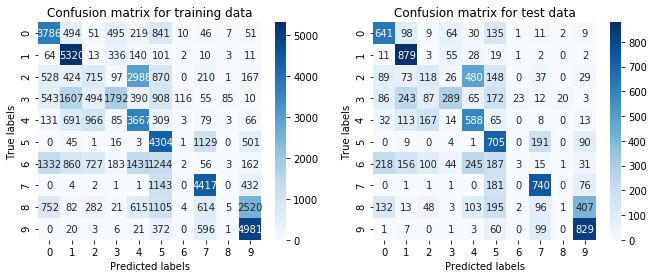

In [24]:
# Create figure
fig, ax = plt.subplots(1,2, figsize=(11,4))

# Plot confusion matrix for training data
sns.heatmap(cm_train, annot=True, fmt='g', ax=ax[0], cmap="Blues")
ax[0].set_xlabel('Predicted labels')
ax[0].set_ylabel('True labels')
ax[0].set_title('Confusion matrix for training data')

# Plot confusion matrix for validation data
sns.heatmap(cm_test, annot=True, fmt='g', ax=ax[1], cmap="Blues")
ax[1].set_xlabel('Predicted labels')
ax[1].set_ylabel('True labels')
ax[1].set_title('Confusion matrix for test data')

# Show the result
plt.show()

## Inspecting Fittest Genome

In [25]:
fittest_genome = pickle.load( open('NEAT-results/best_genomes_fashion', 'rb'))[0]

In [26]:
print(fittest_genome)

Key: 99542
Fitness: -1.9472284253652845
Nodes:
	0 DefaultNodeGene(key=0, bias=0.0, response=1.0, activation=identity, aggregation=sum)
	1 DefaultNodeGene(key=1, bias=0.0, response=1.0, activation=winv, aggregation=sum)
	2 DefaultNodeGene(key=2, bias=0.0, response=1.0, activation=identity, aggregation=sum)
	3 DefaultNodeGene(key=3, bias=0.0, response=1.0, activation=winv, aggregation=sum)
	4 DefaultNodeGene(key=4, bias=0.0, response=1.0, activation=identity, aggregation=sum)
	5 DefaultNodeGene(key=5, bias=0.0, response=1.0, activation=winv, aggregation=sum)
	6 DefaultNodeGene(key=6, bias=0.0, response=1.0, activation=wsin, aggregation=sum)
	7 DefaultNodeGene(key=7, bias=0.0, response=1.0, activation=winv, aggregation=sum)
	8 DefaultNodeGene(key=8, bias=0.0, response=1.0, activation=wsin, aggregation=sum)
	9 DefaultNodeGene(key=9, bias=0.0, response=1.0, activation=identity, aggregation=sum)
	24355 DefaultNodeGene(key=24355, bias=0.0, response=1.0, activation=tanh, aggregation=sum)
Conne

In [27]:
used_input_pixels = []
for cg in fittest_genome.connections.values():
    if cg.enabled:
        used_input_pixels.append(cg.key[0])
print(used_input_pixels)

[-116, -160, -157, -250, -132, -48, -139, -62, -111, -201, -82, -8, -211, -161, -175, -25, -115, -150, -19, -243, -200, -254, -98, -53, -86, -96, -166, -54, -163, -158, -106, -206, -176, -117, -104, -67, -179, -255, -119, -142, -119, -14, -242, -154, -104, -20, -120, -50, -208, -207, -75, -36, -140, -66, -136, -95, -244, -216, -251, -244, -23, -80, -72, -89, -59, -117, -144, -124, -37, -215, -44, -71, -75, -178, -86, -193, -222, 24355]


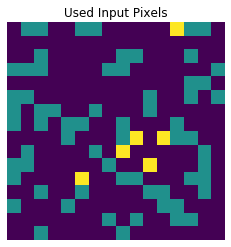

In [29]:
input_tallies = np.zeros(X_train.shape[1])
for arg in used_input_pixels:
    if arg < 0:
        input_tallies[arg] += 1
plt.imshow( input_tallies.reshape(16,16) )
plt.title('Used Input Pixels')
plt.axis('off')
plt.show()